In [1]:
import pandas as pd
import numpy as np
from utils.abundance_filtering import prevalence_filter
from utils.utils import cv
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score
import shap

from shap_mat.explainer import Explainer
from shap_mat.PCA import customPCA
from shap_mat.PCA_visualizer import PCAVisual

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
bacteria_ab_path = 'data/bacteria_relative_abundance_concat.csv'
prevalent_filter_thr = 0.95
rel_ab_threshold= 1e-5
savefig = True

In [3]:
bacteria_ab = pd.read_csv(bacteria_ab_path,index_col=0)

In [4]:
bacteria_ab_x = bacteria_ab.drop(['CRC', 'study_name'],axis=1)
bacteria_ab_y = bacteria_ab['CRC']
study_names_df = bacteria_ab[['study_name']]

# preprocess
bacteria_ab_x_preval = prevalence_filter(bacteria_ab_x,rel_ab_threshold , prevalent_filter_thr)
# bacteria_ab_preval = pd.concat([bacteria_ab_x_preval,bacteria_ab_y],axis=1)

print(bacteria_ab_x.shape)
bacteria_ab_x.head(2)

(802, 865)


,Bacteroides_plebeius,Bacteroides_dorei,Faecalibacterium_prausnitzii,Eubacterium_eligens,Bacteroides_ovatus,Parabacteroides_distasonis,Ruminococcus_gnavus,Phascolarctobacterium_faecium,Bacteroides_uniformis,Bifidobacterium_longum,...,Lactobacillus_animalis,Serratia_proteamaculans,Prevotella_bergensis,Treponema_sp_OMZ_838,Selenomonas_sp_FOBRC6,Selenomonas_sp_oral_taxon_138,Pseudomonas_helleri,Barnesiella_viscericola,Coprobacter_sp,Acinetobacter_pittii
SAMD00114722,0.000131,0.040444,0.006118,0.00954,0.009849,0.044138,0.080406,0.000000,0.032940,0.006659,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
SAMD00114723,0.000002,0.000000,0.007468,0.00000,0.000011,0.009587,0.014821,0.004957,0.000117,0.006459,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# PCA of SHAP values

In [5]:
study_names_unique = study_names_df['study_name'].unique()

results = {}
for study in study_names_unique:
    train_idx = study_names_df[study_names_df['study_name']!=study].index
    test_idx = study_names_df[study_names_df['study_name']==study].index
    
    # print(len(train_idx))
    # print(len(test_idx))
    # print(len(train_idx)+len(test_idx)==len(bacteria_ab_x))
    
    X_train = bacteria_ab_x.loc[train_idx]
    y_train = bacteria_ab_y.loc[train_idx]
    X_test = bacteria_ab_x.loc[test_idx]
    y_test = bacteria_ab_y.loc[test_idx]
     
    
    # model
    # n_estimators_dict = {'YachidaS_2019':100, 'ZellerG_2014':100, 'WirbelJ_2018':100, 'VogtmannE_2016':1000, 'YuJ_2015':500}
    n_estimators_dict = {'YachidaS_2019':1000, 'ZellerG_2014':100, 'WirbelJ_2018':500, 'VogtmannE_2016':1000, 'YuJ_2015':500}

    clf_1 = RandomForestClassifier(n_estimators=n_estimators_dict[study],n_jobs=-1,random_state=0)
    
    # Train RF model
    clf_1.fit(X_train,y_train)
    
    # Prediction and evaluation
    y_pred_proba = clf_1.predict_proba(X_test)[:, 1] # CRC proba
    y_pred_proba = pd.DataFrame(y_pred_proba,index=X_test.index)
    auc_lodo = roc_auc_score(y_true=y_test.values, y_score=y_pred_proba).round(3)

    print(f'{study} | LODO-AUC: {auc_lodo}')

    # Get SHAP of test data
    explainer = Explainer(X=X_test,y=y_test,model=clf_1)
    shap_values = explainer.shap()
    shap_values_df = explainer.shap_df()
    
    # Get PC1, and PC2 and the cumulative var as df
    PCA = customPCA(X=shap_values_df,crc_proba=y_pred_proba)
    shap_PC = PCA.PCA_scores()
    cumulative_var_PC = PCA.cumulative_explained_variance()
    
    results[study] = {'shap_values':shap_values,'PC_df':shap_PC,'CEV_df':cumulative_var_PC,'auc':auc_lodo,'X_test':X_test,'y_test':y_test,'y_pred_proba':y_pred_proba}
    

YachidaS_2019 | LODO-AUC: 0.723


 97%|=================== | 644/662 [00:36<00:01]       

ZellerG_2014 | LODO-AUC: 0.771
WirbelJ_2018 | LODO-AUC: 0.894
YuJ_2015 | LODO-AUC: 0.867
VogtmannE_2016 | LODO-AUC: 0.766


 97%|=================== | 202/208 [00:16<00:00]       

# Global Explanations (Summary Plots)

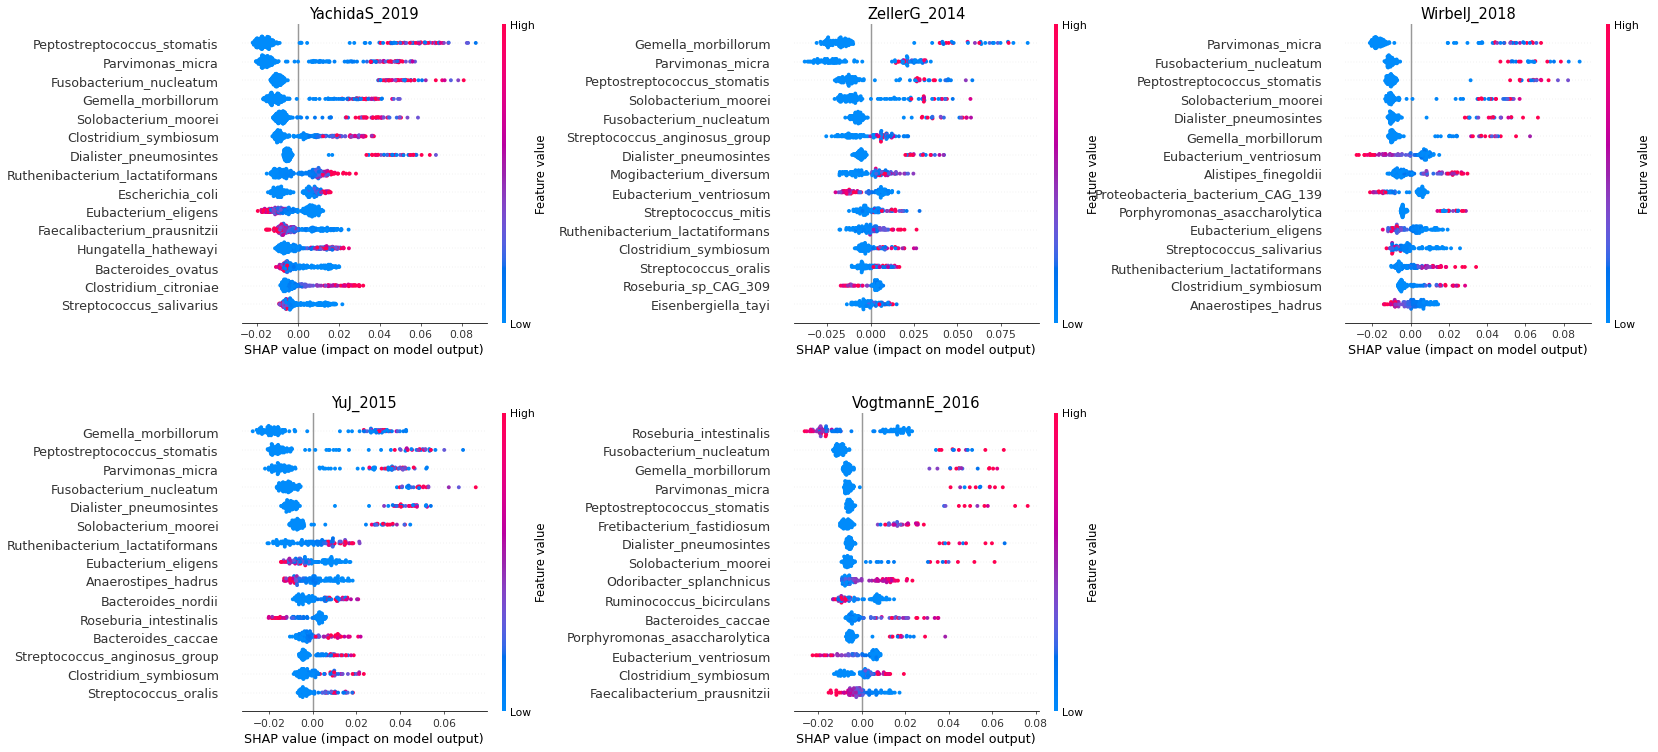

In [6]:
nrows, ncols = 2,3
study_names = list(results.keys())

fig = plt.figure(figsize=(26,13),dpi=70)
for i in range(1,len(results)+1):
    ax = fig.add_subplot(nrows, ncols, i)
    study_name = study_names[i-1]
    shap_values = results[study_name]['shap_values']
    X = results[study_name]['X_test']
    
    shap.summary_plot(shap_values,X,show=False,plot_size=None, max_display=15)
    plt.title(study_name,fontsize=15)

plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.8, hspace=0.3)
if savefig:
    plt.savefig('output/images/paper/tif/summary_plots.tif',format='tif',bbox_inches='tight')
    plt.savefig('output/images/paper/png/summary_plots.png',format='tif',bbox_inches='tight')
plt.show()

# Suplot of PC viz

In [7]:
# for study in results:
#     print(study, results[study]['auc'])
#     shap_PC=results[study]['PC_df']
#     cumulative_var_PC = results[study]['CEV_df']
#     y_test= results[study]['y_test']
    
#     PCA_visualizer = PCAVisual(PC_df=shap_PC,CEV_df=cumulative_var_PC,y=y_test)
#     PCA_visualizer.plot_pca(figsize=(8,8))

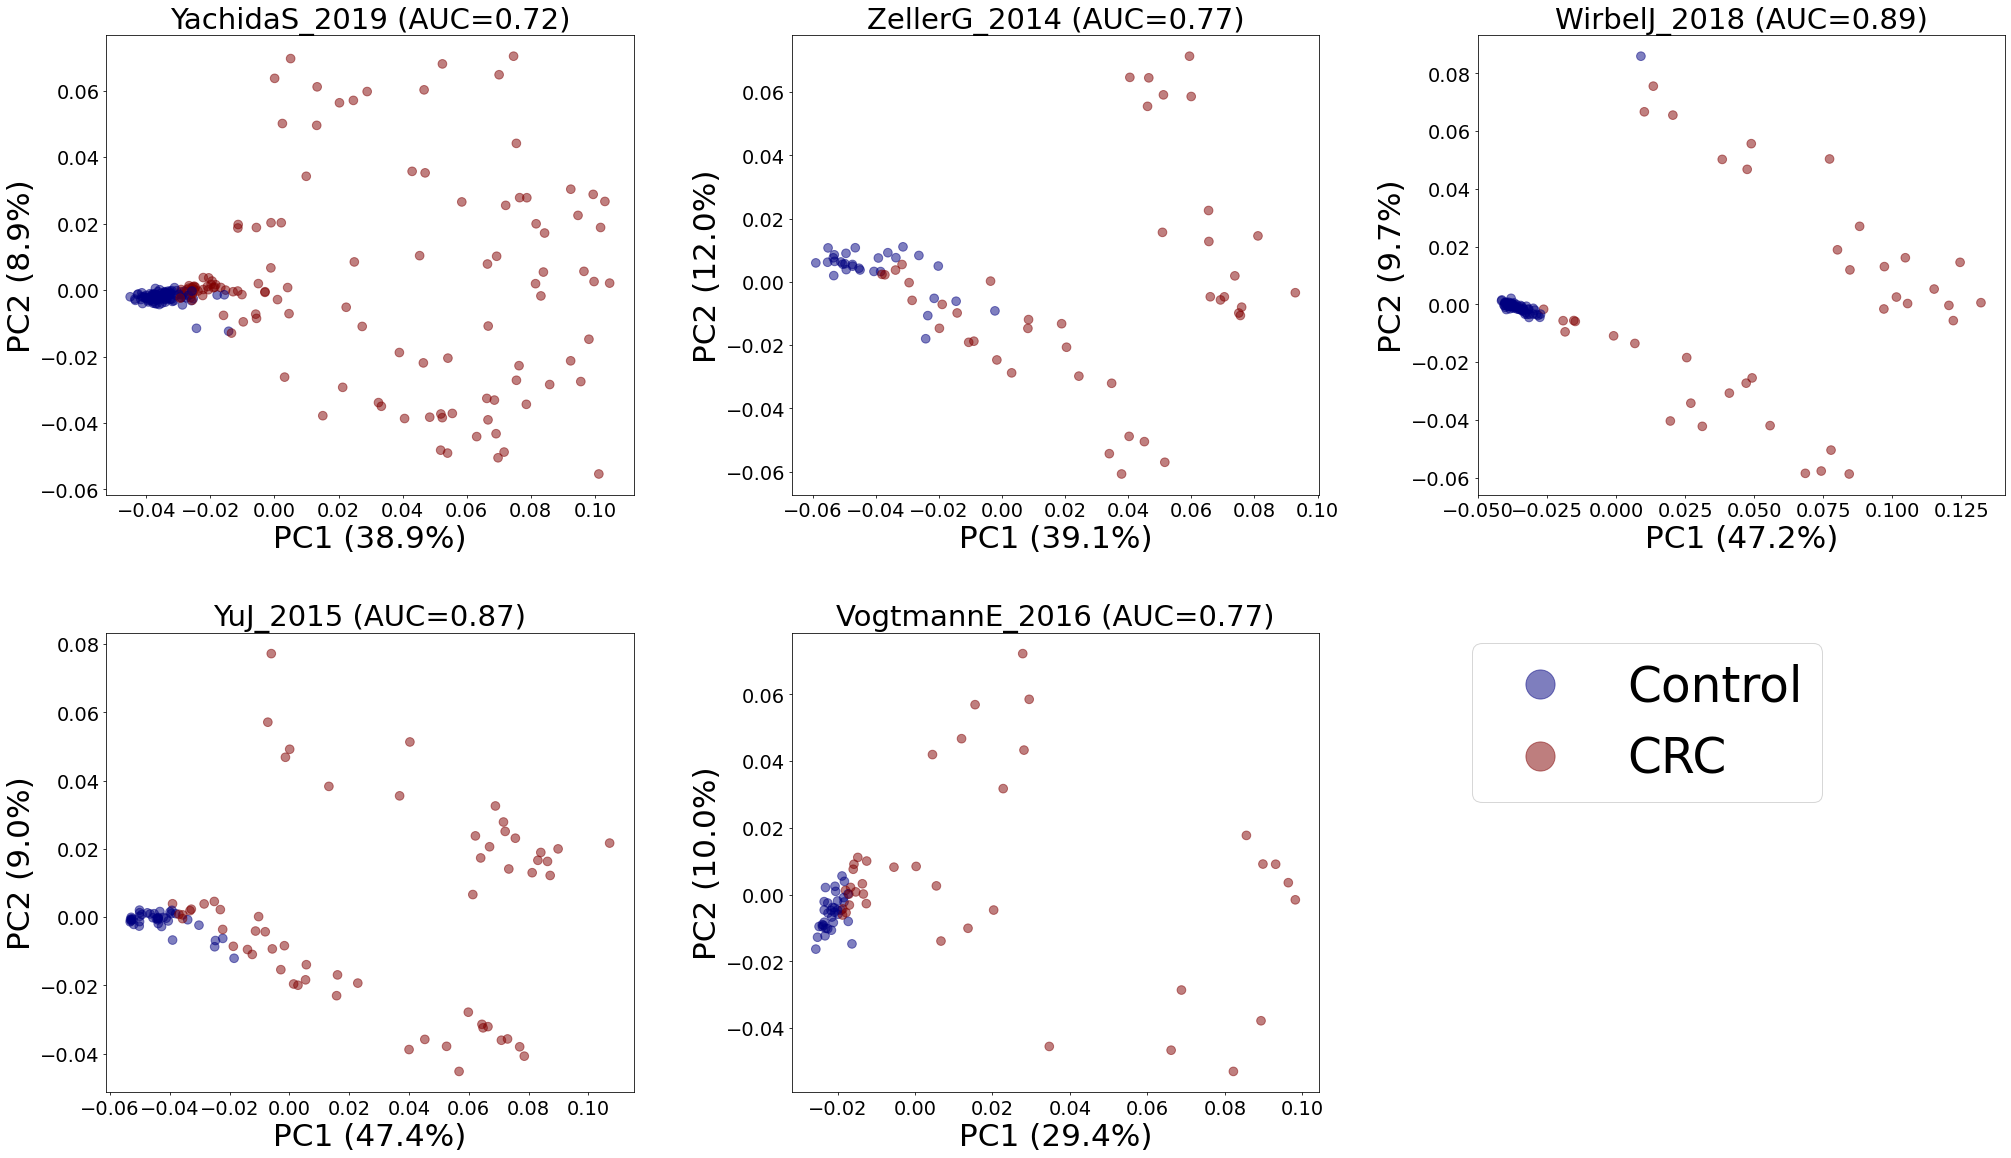

In [8]:
nrows, ncols = 2,3
study_names = list(results.keys())

fig = plt.figure(figsize=(35,20),dpi=70)
for i in range(1,len(results)+1):
    ax = fig.add_subplot(nrows, ncols, i)
        
    # print(study_names[i], results[study_names[i]['auc'])
    shap_PC=results[study_names[i-1]]['PC_df']
    cumulative_var_PC = results[study_names[i-1]]['CEV_df']
    y_test= results[study_names[i-1]]['y_test']
    
    y_correct = y_test.loc[shap_PC.index]    
    
    scatter = ax.scatter(shap_PC['PC1'],shap_PC['PC2'],s=80,c=y_correct,cmap='jet',alpha=0.5)           

    # handles,labels = scatter.legend_elements()
    # legend = plt.legend(handles,labels,fontsize=30,loc='upper left') # ,bbox_to_anchor = (1.42, 1.03))
    # legend.get_texts()[0].set_text('Control')
    # legend.get_texts()[1].set_text('CRC')

    # explained variance
    EV_PC1 = cumulative_var_PC['Explained Variance'][0].round(3)*100
    EV_PC2 = cumulative_var_PC['Explained Variance'][1].round(3)*100
    
    EV_PC1 = round(EV_PC1,2)
    EV_PC2 = round(EV_PC2,2)

    plt.xlabel(f'PC1 ({EV_PC1}%)',fontsize=32)
    plt.ylabel(f'PC2 ({EV_PC2}%)',fontsize=32)

    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    # plt.title(f"{study_names[i-1]} (n={len(y_correct)},AUC={results[study_names[i-1]]['auc'].round(3)})",fontsize=30)
    plt.title(f"{study_names[i-1]} (AUC={results[study_names[i-1]]['auc'].round(2)})",fontsize=30)
    
    if i==5:
        handles,labels = scatter.legend_elements()
        legend = plt.legend(handles,labels,fontsize=50,bbox_to_anchor = (2, 1.03)) # bbox_to_anchor = (1.42, 1.03)), loc='best'
        legend.get_texts()[0].set_text('Control')
        legend.get_texts()[1].set_text('CRC')
        
        legend.legendHandles[0]._legmarker.set_markersize(30)
        legend.legendHandles[1]._legmarker.set_markersize(30)
    
    

plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.3, hspace=0.3)
# plt.tight_layout()
if savefig:
    plt.savefig('output/images/paper/tif/PCA.tif',format='tif',bbox_inches='tight')
    plt.savefig('output/images/paper/png/PCA.png',format='png',bbox_inches='tight')
plt.show()

# PCA of relative abundance data

In [32]:
results_pca_ab = {}
study_names = list(results.keys())

for study in study_names:
    test_idx = study_names_df[study_names_df['study_name']==study].index
    X_test = bacteria_ab_x.loc[test_idx]
    y_test = bacteria_ab_y.loc[test_idx]
    
    # Get PC1, and PC2 and the cumulative var as df
    PCA = customPCA(X=X_test,crc_proba=None)
    ab_PC = PCA.PCA_scores()
    ab_cumulative_var_PC = PCA.cumulative_explained_variance()

    results_pca_ab[study] = {'PC_df':ab_PC,'CEV_df':ab_cumulative_var_PC,'X_test':X_test,'y_test':y_test,}

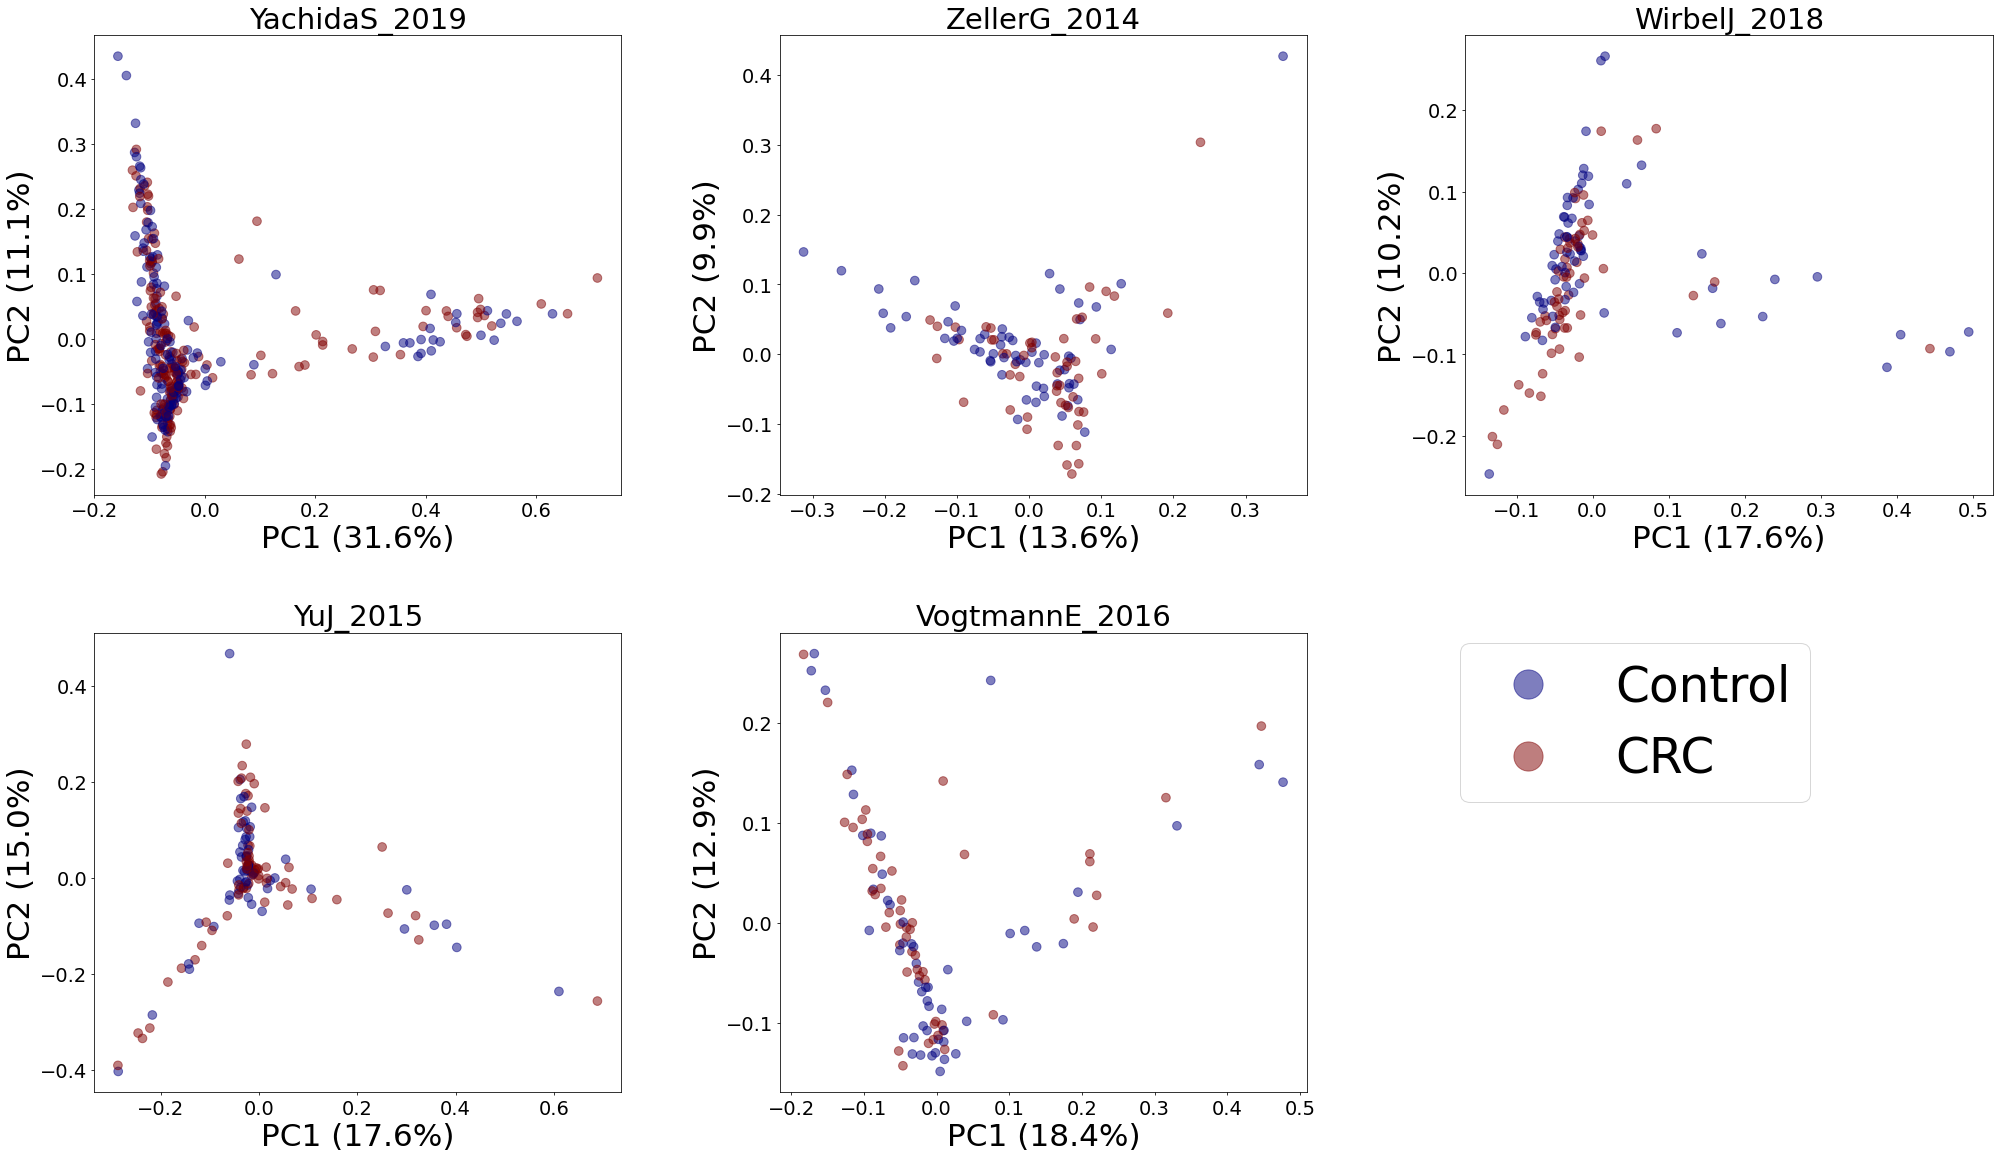

In [34]:
nrows, ncols = 2,3
study_names = list(results.keys())

fig = plt.figure(figsize=(35,20),dpi=70)
for i in range(1,len(results)+1):
    ax = fig.add_subplot(nrows, ncols, i)
        
    ab_PC=results_pca_ab[study_names[i-1]]['PC_df']
    cumulative_var_PC = results_pca_ab[study_names[i-1]]['CEV_df']
    y_test= results_pca_ab[study_names[i-1]]['y_test']
        
    scatter = ax.scatter(ab_PC['PC1'],ab_PC['PC2'],s=80,c=y_test,cmap='jet',alpha=0.5)           


    # explained variance
    EV_PC1 = cumulative_var_PC['Explained Variance'][0].round(3)*100
    EV_PC2 = cumulative_var_PC['Explained Variance'][1].round(3)*100
    
    EV_PC1 = round(EV_PC1,2)
    EV_PC2 = round(EV_PC2,2)

    plt.xlabel(f'PC1 ({EV_PC1}%)',fontsize=32)
    plt.ylabel(f'PC2 ({EV_PC2}%)',fontsize=32)

    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    # plt.title(f"{study_names[i-1]} (n={len(y_correct)},AUC={results[study_names[i-1]]['auc'].round(3)})",fontsize=30)
    plt.title(f"{study_names[i-1]}",fontsize=30)
    
    if i==5:
        handles,labels = scatter.legend_elements()
        legend = plt.legend(handles,labels,fontsize=50,bbox_to_anchor = (2, 1.03)) # bbox_to_anchor = (1.42, 1.03)), loc='best'
        legend.get_texts()[0].set_text('Control')
        legend.get_texts()[1].set_text('CRC')
        
        legend.legendHandles[0]._legmarker.set_markersize(30)
        legend.legendHandles[1]._legmarker.set_markersize(30)
    
    

plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.3, hspace=0.3)
# plt.tight_layout()
if savefig:
    plt.savefig('output/images/paper/tif/PCA_abundance.tif',format='tif',bbox_inches='tight')
    plt.savefig('output/images/paper/png/PCA_abundance.png',format='png',bbox_inches='tight')
plt.show()

## PCA with Predicted P(CRC)

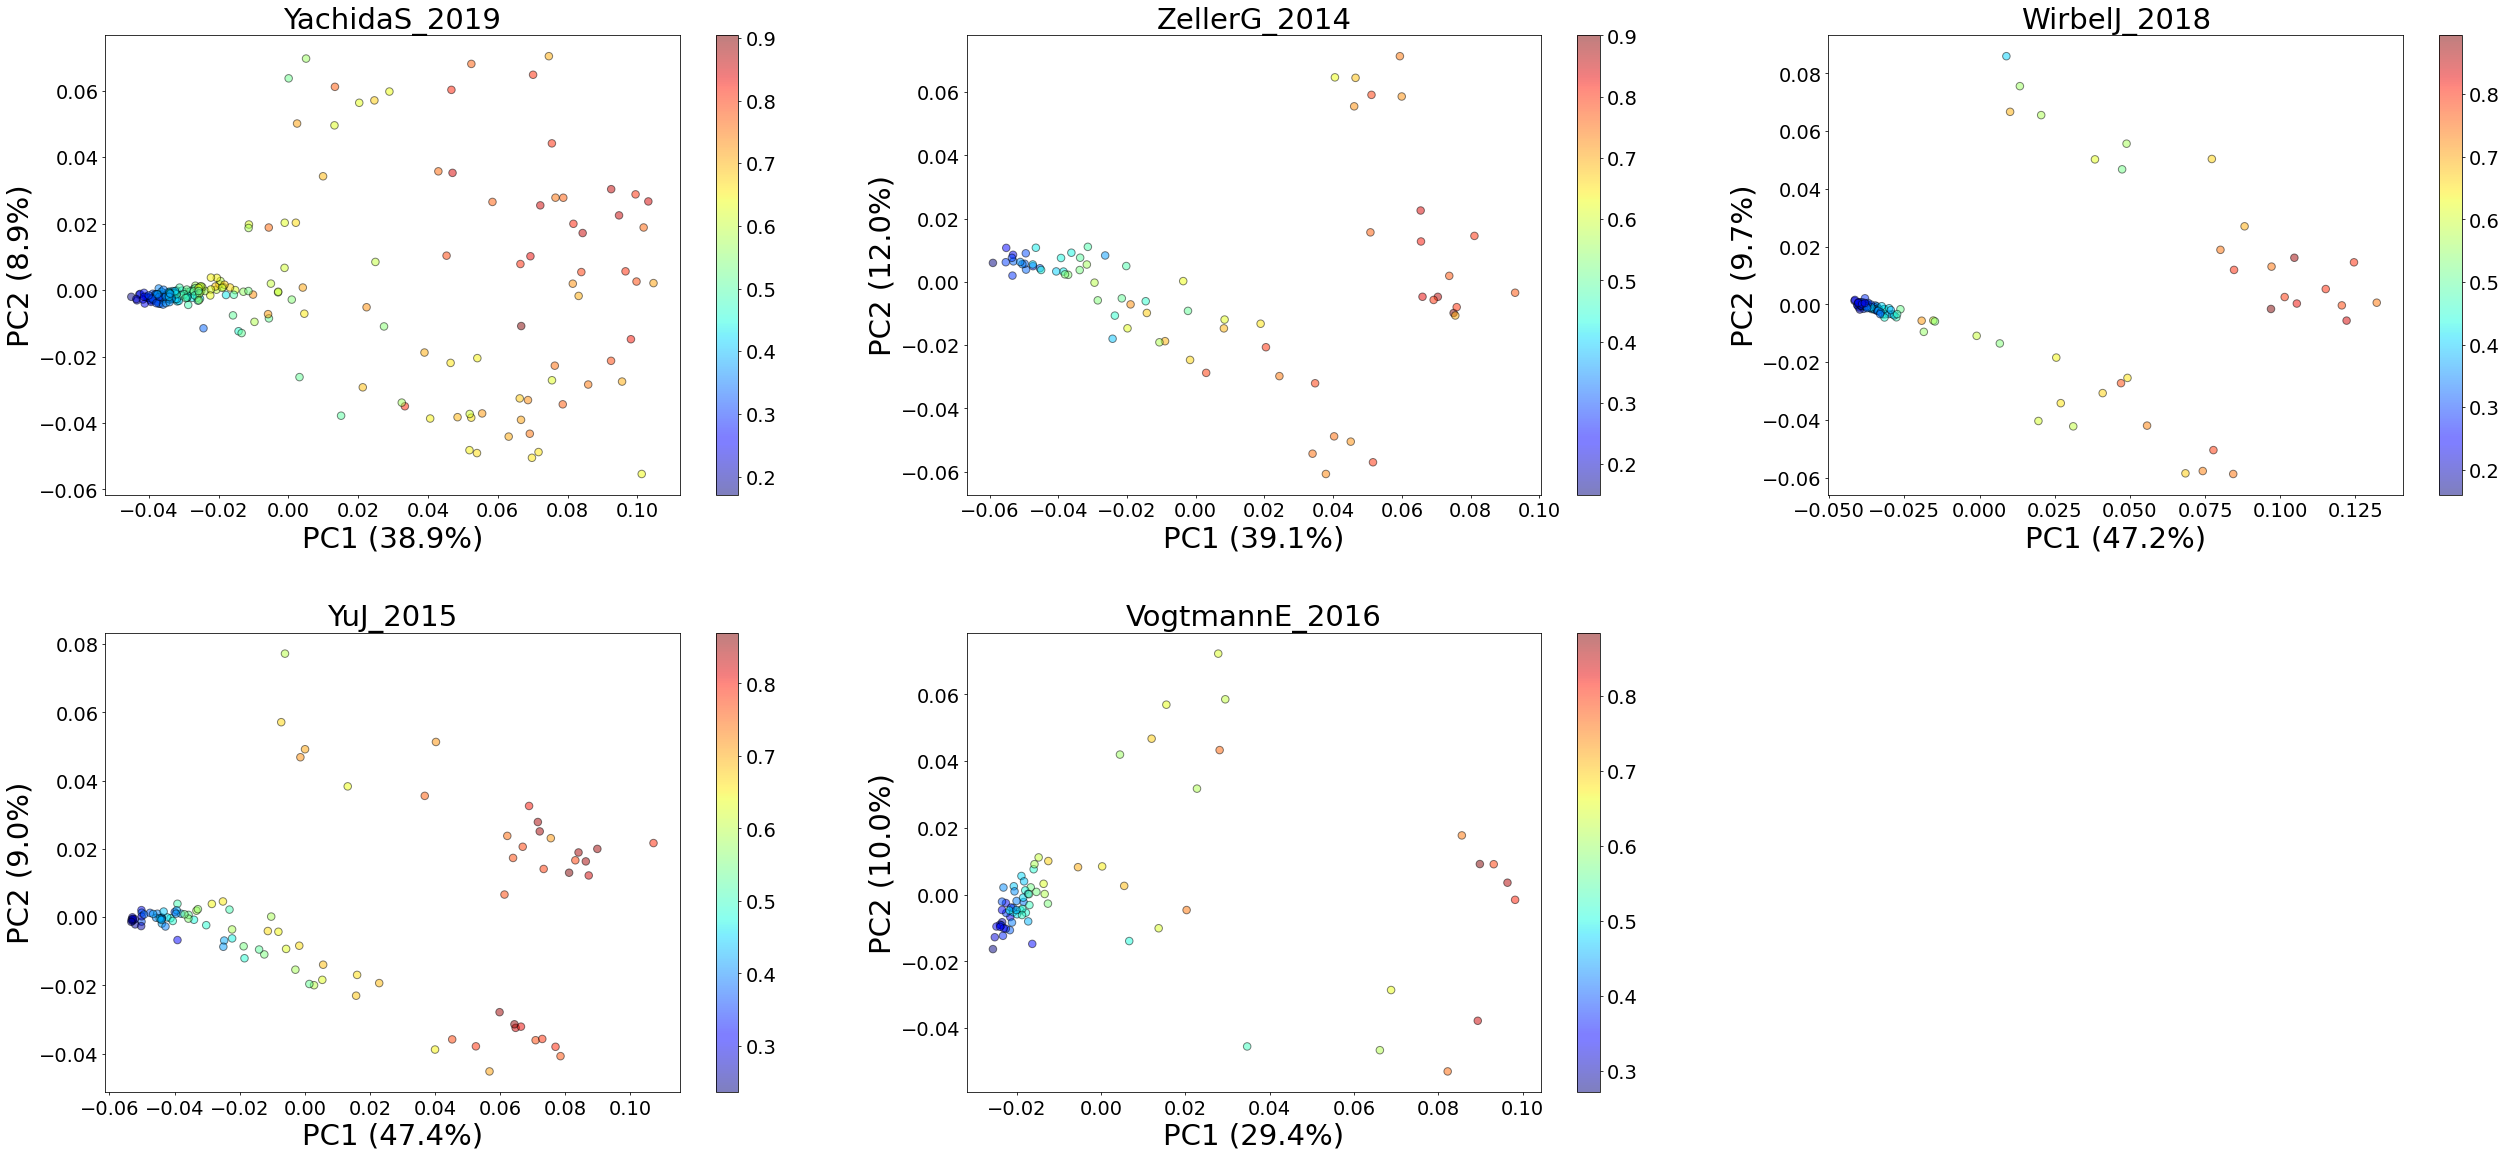

In [24]:
nrows, ncols = 2,3
study_names = list(results.keys())

fig = plt.figure(figsize=(45,20),dpi=70)
for i in range(1,len(results)+1):
    ax = fig.add_subplot(nrows, ncols, i)
        
    # print(study_names[i], results[study_names[i]['auc'])
    shap_PC=results[study_names[i-1]]['PC_df']
    cumulative_var_PC = results[study_names[i-1]]['CEV_df']
    y_pred_proba= results[study_names[i-1]]['y_pred_proba']
    y_pred_proba_correct = y_pred_proba.loc[shap_PC.index]  
    
    scatter = ax.scatter(shap_PC['PC1'],shap_PC['PC2'],
                     s=60,c=y_pred_proba_correct.values,cmap='jet',alpha=0.5,linewidths=1, edgecolors='black') 

    cbar = fig.colorbar(scatter)    
    cbar.ax.tick_params(labelsize=20) 

    # explained variance
    EV_PC1 = cumulative_var_PC['Explained Variance'][0].round(3)*100
    EV_PC2 = cumulative_var_PC['Explained Variance'][1].round(3)*100
    
    EV_PC1 = round(EV_PC1,2)
    EV_PC2 = round(EV_PC2,2)

    plt.xlabel(f'PC1 ({EV_PC1}%)',fontsize=30)
    plt.ylabel(f'PC2 ({EV_PC2}%)',fontsize=30)

    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    plt.title(f"{study_names[i-1]}",fontsize=30)
    
    

plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.2, hspace=0.3)
# plt.tight_layout()
if savefig:
    plt.savefig('output/images/paper/tif/PCA_proba.tif',format='tif',bbox_inches='tight')
    plt.savefig('output/images/paper/png/PCA_proba.png',format='png',bbox_inches='tight')

plt.show()    

# K-means Clustering

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import shap

class clusterCRC:
    """
    Cluster PC1 and PC2 of CRC patients using k-mean clustering
    Args:
        - PC_scores: a dataframe of PC1 and PC2 
        - y: a series of labels with Patient_id as its indices
    """
    def __init__(self,PC_scores,y):
        self.PC_scores = PC_scores
        self.y = y 
        
    def get_CRC_only(self):
        """
        Get PC1 and PC2 of CRC patients only.
        """
        y = self.y
        PC_scores = self.PC_scores
        
        # get the Patient_ID of CRC patients
        CRC_idx = []
        for i in y.index:
            if y.loc[i] == 1:
                CRC_idx.append(i)

        PC_CRC = PC_scores.loc[CRC_idx]
        return PC_CRC
    
    def kmeans(self,n_clusters):
        PC_CRC = self.get_CRC_only()

        kmeans = KMeans(n_clusters=n_clusters
        , init='k-means++', max_iter=1000, n_init=10, random_state=0)
        
        y_pred_kmeans = kmeans.fit_predict(PC_CRC)
        cluster_labels = [y+1 for y in y_pred_kmeans]

        PC_CRC['cluster'] = [y+1 for y in kmeans.labels_]
        return PC_CRC

In [14]:
def reassign_cluster_labels(CRC_kmeans_result_i):
    # Reassign cluster labels for consistency
    mean_PC_percluster = CRC_kmeans_result_i.groupby('cluster').median()

    max_PC1 = mean_PC_percluster['PC1'].max()
    max_PC2 = mean_PC_percluster['PC2'].max()
    min_PC1 = mean_PC_percluster['PC1'].min()
    min_PC2 = mean_PC_percluster['PC2'].min()
    
    # print('MIN MAX PC:',max_PC1,max_PC2,min_PC1,min_PC2)

    assign_label = {} # {init_label: new_label}

    # c1: highest mean PC1
    init_label_1 = mean_PC_percluster[mean_PC_percluster['PC1']==max_PC1].index[0]
    assign_label[init_label_1] = 1

    # c2: lowest mean PC1
    init_label_2 = mean_PC_percluster[mean_PC_percluster['PC1']==min_PC1].index[0]
    assign_label[init_label_2] = 2

    # c3: lowest mean PC2
    init_label_3 = mean_PC_percluster[mean_PC_percluster['PC2']==min_PC2].index[0]
    assign_label[init_label_3] = 3

    # c4: highest mean PC2
    init_label_4 = mean_PC_percluster[mean_PC_percluster['PC2']==max_PC2].index[0]
    assign_label[init_label_4] = 4
    
#     print(mean_PC_percluster)
#     print(assign_label)
    
    return assign_label

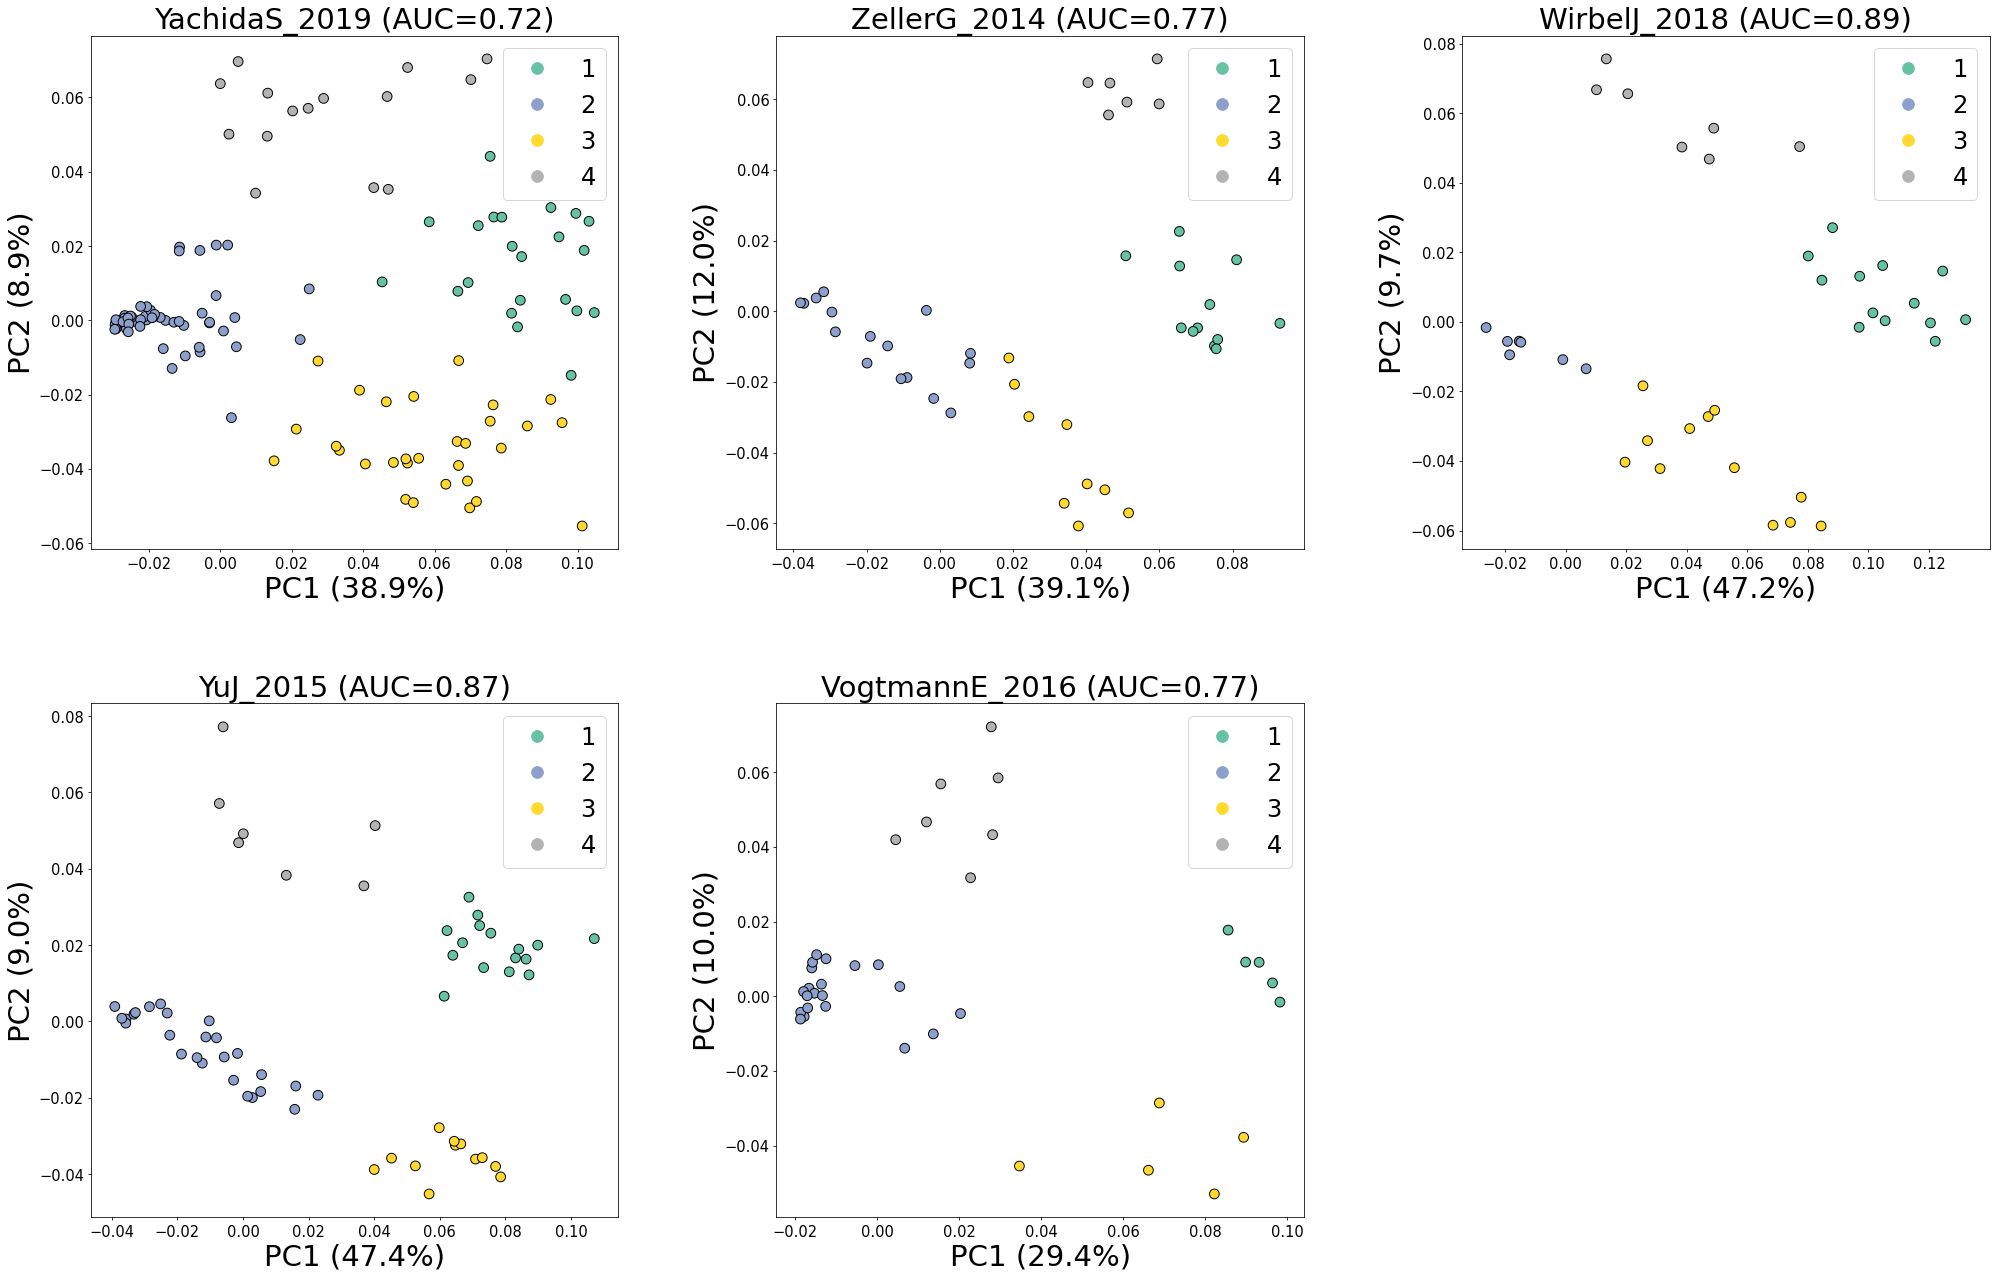

In [15]:
nrows, ncols = 3,3
study_names = list(results.keys())
n_clusters = {'YachidaS_2019':4, 'ZellerG_2014':4, 'FengQ_2015':4, 'WirbelJ_2018':4, 'VogtmannE_2016':4, 'YuJ_2015':4}

cluster_assigned = [] 

fig = plt.figure(figsize=(35,35),dpi=70)
for i in range(1,len(results)+1):
    study_name = study_names[i-1]
    
    ax = fig.add_subplot(nrows, ncols, i)
    shap_PC=results[study_name]['PC_df']
    cumulative_var_PC = results[study_name]['CEV_df']
    y_test= results[study_name]['y_test']
    
    y_correct = y_test.loc[shap_PC.index]    
    
    # K-means clustering
    n_clust = n_clusters[study_name]
    CRC_kmeans = clusterCRC(PC_scores=shap_PC,y=y_correct)
    CRC_kmeans_df = CRC_kmeans.kmeans(n_clusters=n_clust)
    
    # custom cluster names for consistency
    assigned_labels = reassign_cluster_labels(CRC_kmeans_df)
    
    if len(assigned_labels)==4:
        CRC_kmeans_df['cluster'] = CRC_kmeans_df['cluster'].map(assigned_labels)
    
    # manually reassign cluster name for YuJ_2015
    # if study_name== 'YuJ_2015':
    #     CRC_kmeans_df['cluster'] = CRC_kmeans_df['cluster'].map({3:4,4:3,1:1,2:2})
    
    scatter = plt.scatter(CRC_kmeans_df['PC1'],CRC_kmeans_df['PC2'],
                    s=100,c=CRC_kmeans_df['cluster'],cmap='Set2',alpha=1,edgecolors='black') 
    
    handles,labels = scatter.legend_elements()
    legend = plt.legend(handles,labels,fontsize=25,loc='best') #,bbox_to_anchor = (1.2, 1.03)
    for i in range(n_clust):
        legend.legendHandles[i]._legmarker.set_markersize(12)


    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    plt.title(f"{study_name} (AUC={results[study_name]['auc'].round(2)})",fontsize=30)
    
    # explained variance
    EV_PC1 = cumulative_var_PC['Explained Variance'][0].round(3)*100
    EV_PC2 = cumulative_var_PC['Explained Variance'][1].round(3)*100
    
    EV_PC1 = round(EV_PC1,2)
    EV_PC2 = round(EV_PC2,2)

    plt.xlabel(f'PC1 ({EV_PC1}%)',fontsize=30)
    plt.ylabel(f'PC2 ({EV_PC2}%)',fontsize=30)
    
    # save info about the asigned cluster
    cluster_assigned.append(CRC_kmeans_df[['cluster']])

plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.3, hspace=0.3)
# plt.tight_layout()
if savefig:
    plt.savefig('output/images/paper/tif/kmeans.tif',format='tif',bbox_inches='tight')
    plt.savefig('output/images/paper/png/kmeans.png',format='png',bbox_inches='tight')
plt.show()

### The Elbow Method

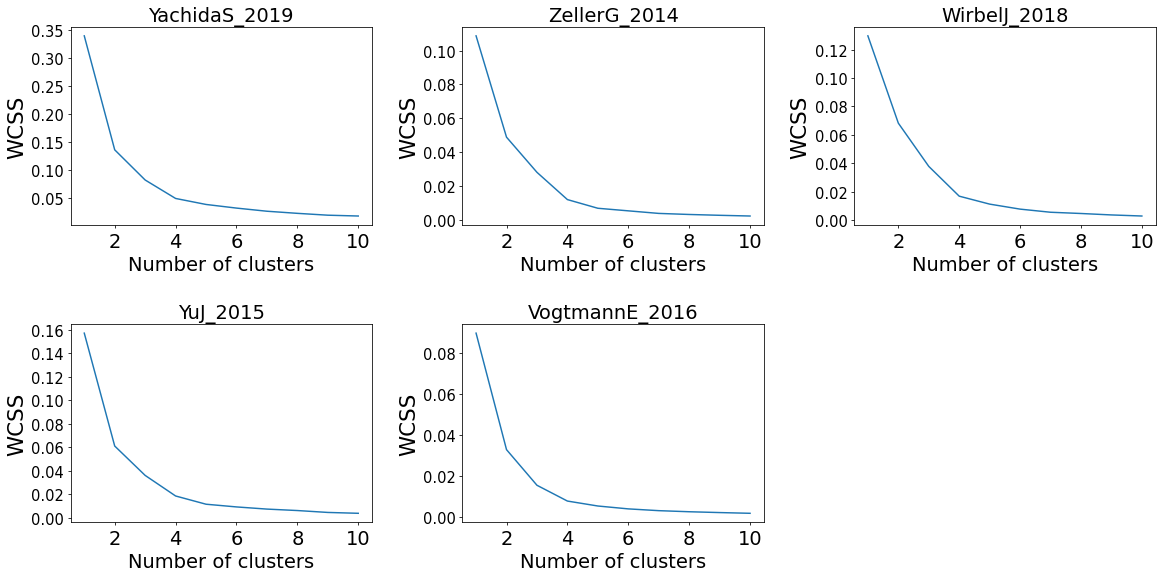

In [16]:
# elbow method
fig = plt.figure(figsize=(20,15),dpi=70)
for i in range(1,len(results)+1):
    study_name = study_names[i-1]
    
    ax = fig.add_subplot(nrows, ncols, i)
    shap_PC=results[study_name]['PC_df']
    cumulative_var_PC = results[study_name]['CEV_df']
    y_test= results[study_name]['y_test']
    
    y_correct = y_test.loc[shap_PC.index]    
    
    # K-means clustering
    n_clust = n_clusters[study_name]
    CRC_kmeans = clusterCRC(PC_scores=shap_PC,y=y_correct)
    CRC_kmeans_df = CRC_kmeans.kmeans(n_clusters=n_clust)
    
    wcss = []
    for i in range(1,11):
        model = KMeans(n_clusters = i, init = "k-means++")
        model.fit(CRC_kmeans_df[['PC1','PC2']])
        wcss.append(model.inertia_)
    ax.plot(range(1,11), wcss)
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=15)
    plt.xlabel('Number of clusters',fontsize=20)
    plt.ylabel('WCSS',fontsize=22)
    plt.title(study_name,fontsize=20)

plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.3, hspace=0.5)
if savefig:
    plt.savefig('output/images/paper/tif/kmeans_elbow.tif',format='tif',bbox_inches='tight')
    plt.savefig('output/images/paper/png/kmeans_elbow.png',format='png',bbox_inches='tight')
plt.show()

### Save info about the assigned clusters

In [17]:
cluster_assigned_df = pd.concat(cluster_assigned)
cluster_assigned_df.head(2)

,cluster
SAMD00114722,4
SAMD00114723,2


In [18]:
cluster_assigned_df.to_csv('data/tables/cluster_assign.csv')

### P(CRC) of each cluster

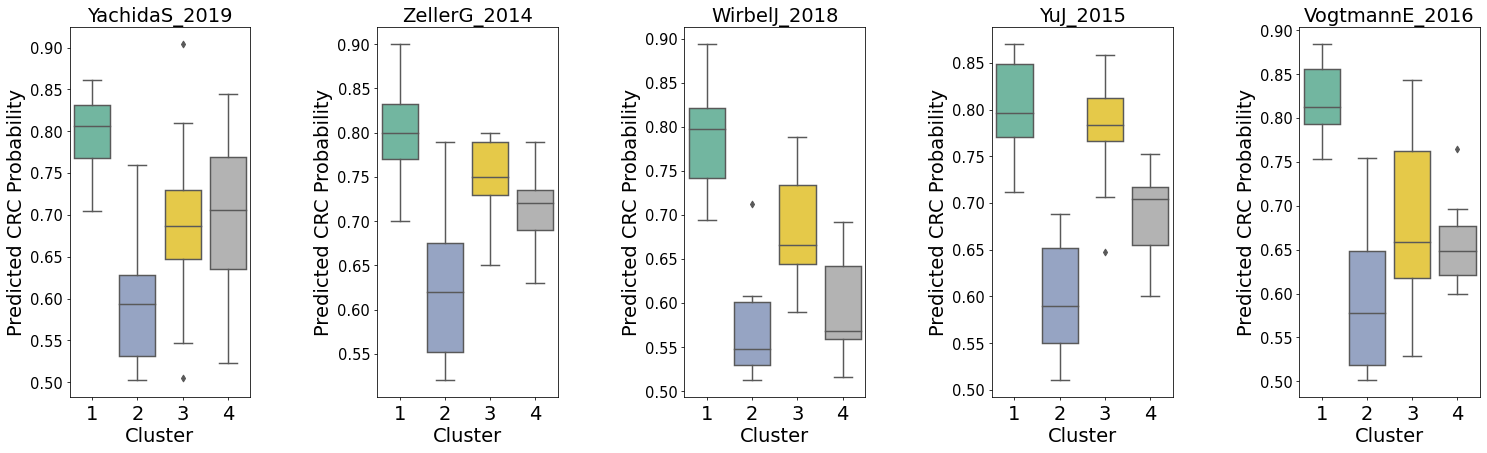

In [19]:
my_pallete = {1:"#66c2a4", 2:"#8ea1ca", 3:"#ffd92f",4:'#b3b3b3'}
fig = plt.figure(figsize=(26,7),dpi=70)

nrows, ncols= 1, 5
for i in range(1,len(results)+1):
    study_name = study_names[i-1]
    ax = fig.add_subplot(nrows, ncols, i)
    
    crc_proba = results[study_name]['y_pred_proba']
    crc_proba.columns = ['P(CRC)']
    crc_proba = crc_proba.join(cluster_assigned_df,how='inner')

    sns.boxplot(x='cluster',y='P(CRC)', data= crc_proba, palette=my_pallete)
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=15)

    plt.ylabel('Predicted CRC Probability',fontsize=20)
    plt.xlabel('Cluster',fontsize=20)
    plt.title(study_name,fontsize=20)

plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.7, hspace=None)
if savefig:
    plt.savefig('output/images/paper/tif/boxplot_proba.tif',format='tif',bbox_inches='tight')
    plt.savefig('output/images/paper/png/boxplot_proba.png',format='png',bbox_inches='tight')
plt.show()